# Knowledge Graph Agent

Let's build a knowledge graph agent to extract structured information from an unstructured text input.

Our agent will take a text input and will return a list of nodes and edges that represent the knowledge graph.

---

### Tools:
- DeepSeek: The LLM provider which we will use to perform the inference, acting as the brain of the agent.

- Pydantic: a data validation and settings management library for Python, pydantic models will be used to define the nodes and edges of our knowledge graph, as well as the input and output schemas we need to pass to the LLM.

- Instructor: a library that will be used to chain the models together. It allows us to get structured outputs from the LLM.

---

### Let's begin by installing the necessary libraries and importing them so we can start building our agent:

You also will require an API key for the DeepSeek LLM provider. You can get one by signing up in the API console [here](https://www.deepseek.com/).

You can also replace this with any other LLM provider of your choice, but I am using DeepSeek R1.

In [13]:
%pip install openai pydantic python-dotenv openai instructor graphviz eval_type_backport --quiet

import os
import openai
import instructor
from pydantic import BaseModel
from typing import List
from dotenv import load_dotenv
import graphviz
from IPython.display import Image, display

load_dotenv()
DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")

Note: you may need to restart the kernel to use updated packages.


---

### Now, we define the different  complex data structures we will use in our project:

We will use Pydantic to define the structures.


In [8]:
class Node(BaseModel):
    label: str
    entity_type: str


class Edge(BaseModel):
    source: Node
    target: Node
    label: str


class Graph(BaseModel):
    nodes: List[Node]
    edges: List[Edge]


class InferenceRequest(BaseModel):
    text: str
    graph: Graph


class InferenceResponse(BaseModel):
    new_nodes: List[Node]
    new_edges: List[Edge]

### Great! Let's tell the agent what we want it to do:

The prompt variable is the instruction we are giving to the agent. In this case, we are telling the agent to extract all structured information from an unstructured text input. We can modify this in the future to extract specific information, such as only the names of people, and their relationships.

The input variable is the text input we are giving to the agent. In this case, we are giving it a short description of Socrates, a Greek philosopher taken from [Wikipedia](https://en.wikipedia.org/wiki/Socrates).

In [9]:
prompt = """
You are a knowledge graph agent that extracts structured information from an unstructured text input. Take the information that the user provides, and create a graph of it to make it easy to understand.
"""

input = """
Socrates (/ˈsɒkrətiːz/;[2] Ancient Greek: Σωκράτης, romanized: Sōkrátēs; c. 470 – 399 BC) was a Greek philosopher from Athens who is credited as the founder of Western philosophy[3] and as among the first moral philosophers of the ethical tradition of thought. An enigmatic figure, Socrates authored no texts and is known mainly through the posthumous accounts of classical writers, particularly his students Plato and Xenophon. These accounts are written as dialogues, in which Socrates and his interlocutors examine a subject in the style of question and answer; they gave rise to the Socratic dialogue literary genre. Contradictory accounts of Socrates make a reconstruction of his philosophy nearly impossible, a situation known as the Socratic problem. Socrates was a polarizing figure in Athenian society. In 399 BC, he was accused of impiety and corrupting the youth. After a trial that lasted a day, he was sentenced to death. He spent his last day in prison, refusing offers to help him escape.

"""

### Perfect! Now, we sit back and let the agent do its thing!

In [11]:
client = instructor.from_openai(openai.OpenAI(api_key=DEEPSEEK_API_KEY, base_url="https://api.deepseek.com/v1"))

response = client.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": prompt},
        {"role": "user", "content": input},
    ],
    stream=False,
    response_model=InferenceResponse
)

New Nodes:  [Node(label='Socrates', entity_type='Person'), Node(label='Athens', entity_type='Place'), Node(label='Western philosophy', entity_type='Concept'), Node(label='Moral philosophy', entity_type='Concept'), Node(label='Ethical tradition of thought', entity_type='Concept'), Node(label='Plato', entity_type='Person'), Node(label='Xenophon', entity_type='Person'), Node(label='Socratic dialogue', entity_type='Literary Genre'), Node(label='Socratic problem', entity_type='Concept'), Node(label='Impiety', entity_type='Concept'), Node(label='Corrupting the youth', entity_type='Concept'), Node(label='399 BC', entity_type='Date')]
New Edges:  [Edge(source=Node(label='Socrates', entity_type='Person'), target=Node(label='Athens', entity_type='Place'), label='from'), Edge(source=Node(label='Socrates', entity_type='Person'), target=Node(label='Western philosophy', entity_type='Concept'), label='credited as the founder of'), Edge(source=Node(label='Socrates', entity_type='Person'), target=Node(

### Let's see the information we extracted

In [20]:
for obj in response.new_nodes:
    print("Node: ", obj.label, "-", obj.entity_type)

print("\n\n")
for obj in response.new_edges:
    print("Edge: ", obj.source.label, "->", obj.target.label, "(", obj.label, ")")


Node:  Socrates - Person
Node:  Athens - Place
Node:  Western philosophy - Concept
Node:  Moral philosophy - Concept
Node:  Ethical tradition of thought - Concept
Node:  Plato - Person
Node:  Xenophon - Person
Node:  Socratic dialogue - Literary Genre
Node:  Socratic problem - Concept
Node:  Impiety - Concept
Node:  Corrupting the youth - Concept
Node:  399 BC - Date



Edge:  Socrates -> Athens ( from )
Edge:  Socrates -> Western philosophy ( credited as the founder of )
Edge:  Socrates -> Moral philosophy ( among the first of )
Edge:  Socrates -> Ethical tradition of thought ( among the first of )
Edge:  Socrates -> Plato ( student of )
Edge:  Socrates -> Xenophon ( student of )
Edge:  Socrates -> Socratic dialogue ( gave rise to )
Edge:  Socrates -> Socratic problem ( associated with )
Edge:  Socrates -> Impiety ( accused of )
Edge:  Socrates -> Corrupting the youth ( accused of )
Edge:  Socrates -> 399 BC ( sentenced to death in )


### Visual Representation

Text is nice and all, but images are better! Let's convert our nodes and edges into an image!

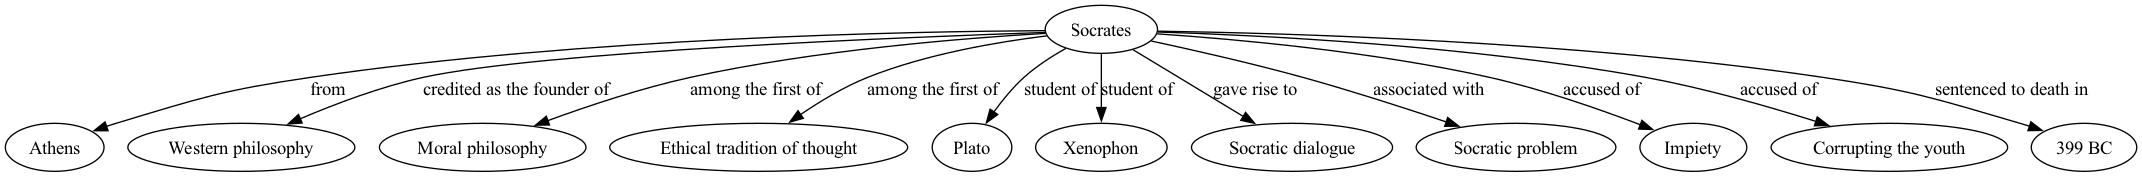

In [18]:
dot = graphviz.Digraph()

for node in response.new_nodes:
    dot.node(node.label, node.label)

for edge in response.new_edges:
    dot.edge(edge.source.label, edge.target.label, label=edge.label)

dot.render('knowledge_graph', format='png', cleanup=True)  # 'cleanup=True' removes the .dot file

display(Image(filename='knowledge_graph.png'))


## Let's try something more complex!

Let's try and extract a knowledge graph from a conversation.